<a href="https://colab.research.google.com/github/rll/deepul/blob/master/demos/lecture5_gan_models_demos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting Started
Go to **Runtime -> Change runtime type** and make sure **Hardward accelerator** is set to **GPU**

In [0]:
!if [ -d deepul ]; then rm -Rf deepul; fi
!git clone https://github.com/rll/deepul.git 
!pip install ./deepul

!if [ -d pretrained_models ]; then rm -Rf pretrained_models; fi
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1kQ99xvHHg_xT7AuZ4QowxZudJksG817Z' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1kQ99xvHHg_xT7AuZ4QowxZudJksG817Z" -O pretrained_models.zip && rm -rf /tmp/cookies.txt
!unzip -qq pretrained_models.zip
!rm pretrained_models.zip
!rm -r __MACOSX

Cloning into 'deepul'...
remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 715 (delta 3), reused 6 (delta 2), pack-reused 697
Receiving objects: 100% (715/715), 117.87 MiB | 23.35 MiB/s, done.
Resolving deltas: 100% (314/314), done.
Processing ./deepul
  Created wheel for deepul: filename=deepul-0.1.0-cp36-none-any.whl size=16849 sha256=7e1fa749fc9ef379644d92ce2a04b0b057f406902b2923c41ca16dd86b81fe4c
  Stored in directory: /tmp/pip-ephem-wheel-cache-scq9y2x5/wheels/39/1a/4b/a6f51db275abb2e5dae32540e06ed5011e792f162467bd3aa8
Successfully built deepul
--2020-04-25 03:44:40--  https://docs.google.com/uc?export=download&confirm=&id=1kQ99xvHHg_xT7AuZ4QowxZudJksG817Z
Resolving docs.google.com (docs.google.com)... 172.217.5.206, 2607:f8b0:4007:804::200e
Connecting to docs.google.com (docs.google.com)|172.217.5.206|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Lo

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import IPython
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
from scipy.stats import norm
from tqdm import trange, tqdm_notebook
import os.path as osp
import deepul.pytorch_util as ptu
from deepul.demo4_helper import *
from deepul.hw4_helper import load_q2_data
from deepul.utils import show_samples
import warnings
warnings.filterwarnings('ignore')

In [0]:
# setting colab to use cpu
# refer to deepul/pytorch_utils.py for more information on ptu
ptu.set_gpu_mode(False)
ptu.device

device(type='cpu')

# Demo 1: Behavior of different divergences

## Kullback-Leibler (KL) divergence
Generally, we can formulate the problem of using a model $p_{model}$ to fit the data distribution as trying to minimize the divergence $div(p_{model}, p_{data})$. However, it isn't generally clear what the divergence measure should be.

One popular formulation is the Kullback-Leibler divergence, or KL-divergence for short. Mathematically, this is:
$$KL(p||q) = \mathbb{E}_p [\log \frac{p}{q}]$$
This quantity takes on non-negative values, and can be thought of as similar to a distance, although it doesn't satisfy all the properties of a true metric (e.g. $KL(p||q) \neq KL(q||p)$. Thus, minimizing the forward KL term $KL(p_{data} || p_{model})$ tries to make $p_{model}$ close to the data distribution. One nice property of the KL-divergence is that it's super easy to minimize empirically: in lecture, we showed that minimizing the KL is equivalent to doing MLE.

Now, let's see what kind of behavior minimizing this forward KL has. 

### Training code:

In [0]:
import math

def plot_losses(train_losses, test_losses, title, ylabel='NLL'):
    plt.figure()
    n_epochs = len(test_losses) - 1
    x_train = np.linspace(0, n_epochs, len(train_losses))
    x_test = np.arange(n_epochs + 1)

    plt.plot(x_train, train_losses, label='train loss')
    plt.plot(x_test, test_losses, label='test loss')
    plt.legend()
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel(ylabel)
    plt.show()

def train(model, data_distribution, optimizer, loss_fn):
    model.train()
    losses = []
    loss = loss_fn(model, data_distribution)
    optimizer.zero_grad()
    if math.isnan(loss.detach().item()):
        return []
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    return losses

def train_epochs(model, data_distribution, train_args, loss_fn):
    epochs, lr = train_args['epochs'], train_args['lr']
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses, test_losses = [], []
    model.eval()
    test_loss = loss_fn(model, data_distribution).item()
    test_losses.append(test_loss)  # loss at init
    for epoch in tqdm_notebook(range(epochs), desc='Epoch', leave=False):
        model.train()
        epoch_train_losses = train(model, data_distribution, optimizer, loss_fn) 
        train_losses.extend(epoch_train_losses)
        test_losses.extend(epoch_train_losses)
            
    return train_losses, test_losses

### Models:

In [0]:
from torch.distributions.normal import Normal

def kl_divergence(p, q, interval_size=1):
    return (p * (p.log() - q.log())).sum() * interval_size

def kl_divergence_with_logs(p, q, interval_size=1):
    return (p.exp() * (p - q)).sum() * interval_size

def forward_kl(model, data_dist):
    num_steps = 100000
    interval_size = 10.0 / num_steps

    xs = torch.linspace(-5, 5, steps=num_steps).to(ptu.device)
    return kl_divergence_with_logs(data_dist.log_prob(xs), model.log_prob(xs), interval_size=interval_size)

class Gaussian(nn.Module):
    def __init__(self):
        super().__init__()
        self.loc = nn.Parameter(torch.randn(1), requires_grad=True)
        self.log_scale = nn.Parameter(torch.zeros(1), requires_grad=True)

    def log_prob(self, x):
        return Normal(self.loc, self.log_scale.exp()).log_prob(x)
 
    # Compute loss as negative log-likelihood
    def nll(self, x):
        return - self.log_prob(x).mean()

class MOG(nn.Module):
    def __init__(self, weights, locs, scales): 
        super().__init__()
        self.weights = ptu.tensor(weights)
        self.locs = ptu.tensor(locs)
        self.scales = ptu.tensor(scales)
        self.n_components = len(self.weights)

    def log_prob(self, x):
        weights = self.weights.unsqueeze(0).repeat(x.shape[0], 1)
        return (Normal(self.locs, self.scales).log_prob(x.unsqueeze(1).repeat(1, self.n_components)).exp() * weights).sum(dim=1).log()

### Data distribution:

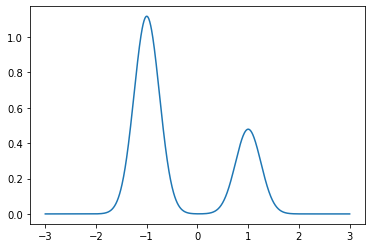

In [0]:
xs = np.linspace(-3, 3, num=1000)
data_distribution = MOG(np.array([0.7, 0.3]),    # mixture weights
                        np.array([-1, 1]),       # means
                        np.array([0.25, 0.25]))  # scales
ys = data_distribution.log_prob(torch.tensor(xs)).exp().numpy()
plt.plot(xs, ys)
plt.show()

### Results:


In [0]:
mle_model = Gaussian().to(ptu.device)
train_losses, test_losses = train_epochs(mle_model, data_distribution, dict(lr=3E-3, epochs=1000), loss_fn = forward_kl)

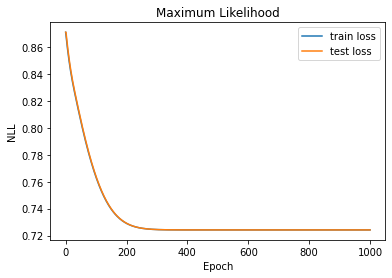

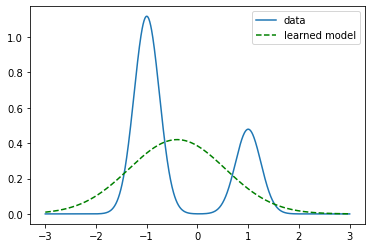

In [0]:
plot_losses(train_losses, test_losses, 'Maximum Likelihood')
plt.plot(xs, ys, label='data')
plt.plot(xs, ptu.get_numpy(mle_model.log_prob(ptu.tensor(xs)).exp()), c='g', linestyle='dashed', label='learned model')
plt.legend()
plt.show()

We see that the forward KL is **mode-covering**. That is, it assigns positive probability to every data point in the training set. However, this comes with a tradeoff: samples from this model will not always look realistic. For example, our learned model will often produce points less than -2, even though such points do not exist in the dataset. Thus, perceptual quality often suffers when using the forward KL.

 ## Reverse KL divergence

 In contrast to the forward KL, we can try to optimize the **reverse KL**, which has form 
 $$KL(p_{model}|| p_{data}) = \mathbb{E}_{p_{model}}[\log p_{model} - \log p_{data}]$$
 In practice, this is very difficult to optimize, since there's no good way to evaluate $p_{data}$ on samples $x \sim p_{model}$. Regardless, we can still analyze the behavior of minimizing the reverse KL in the case where we know $p_{data}$. 

### Loss function:

In [0]:
def reverse_kl(model, data_dist):
    num_steps = 100000
    interval_size = 10.0 / num_steps
    xs = torch.linspace(-5, 5.1, steps=num_steps).to(ptu.device)
    return kl_divergence_with_logs(model.log_prob(xs), data_dist.log_prob(xs), interval_size=interval_size)

### Results

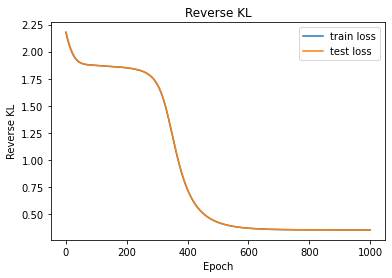

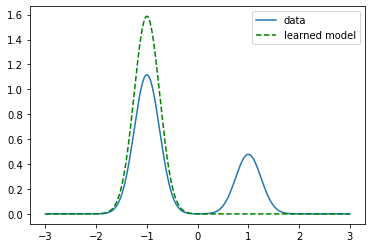

In [0]:
rkl_model = Gaussian().to(ptu.device)
train_losses, test_losses = train_epochs(rkl_model, data_distribution, dict(lr=3E-3, epochs=1000), loss_fn = reverse_kl)
plot_losses(train_losses, test_losses, 'Reverse KL', ylabel='Reverse KL')
plt.plot(xs, ys, label='data')
plt.plot(xs, rkl_model.log_prob(torch.tensor(xs)).exp().detach().numpy(), c='g', linestyle='dashed', label='learned model')
plt.legend()
plt.show()

It turns out that the reverse KL is **mode-seeking**, which means that it puts very little probability mass on samples that don't appear in the data distribution. Thus, the resulting model produces samples that look realistic, but the samples may not be diverse.

## Jensen-Shannon divergence
In lecture, we discussed how the Bayes optimal discriminator takes form 
$$D^*(x) = \frac{p_{data}(x)}{p_{data}(x) + p_{model}(x)}$$
With a little more math, we can show that the optimal generator learns a probability distribution that minimizes the **Jensen-Shannon divergence**, which has form 
$$JSD(P||Q) = \frac{1}{2} D_{KL}(P||M) + \frac{1}{2} D_{KL}(Q||M)$$
where $M$ is the mixture distribution $\frac{1}{2}(P + Q)$. Let's see what kind of behavior the JSD gives rise to. 

### Losses:

In [0]:
def jsd_orig(model, data_dist):
    num_steps = 100000
    interval_size = 6.1 / num_steps

    xs = torch.linspace(-3, 3.1, steps=num_steps).to(ptu.device)
    model_probs = model.log_prob(xs).exp()
    data_probs = data_dist.log_prob(xs).exp()
    mixture_probs = 0.5 * model_probs + 0.5 * data_probs
    kl1 = 0.5 * kl_divergence(model_probs, mixture_probs, interval_size=interval_size)
    kl2 = 0.5 * kl_divergence(data_probs, mixture_probs, interval_size=interval_size)
    if np.isnan(ptu.get_numpy(kl1 + kl2)):
        ipdb.set_trace()
    return kl1 + kl2

def jsd(model, data_dist):
    num_steps = 100000
    interval_size = 6.1 / num_steps

    xs = torch.linspace(-3, 3.1, steps=num_steps).to(ptu.device)
    model_log_probs = model.log_prob(xs)
    model_probs = model_log_probs.exp()
    data_log_probs = data_dist.log_prob(xs)
    data_probs = data_log_probs.exp()
    mixture_probs = 0.5 * model_probs + 0.5 * data_probs
    kl1 = 0.5 * (model_probs * (model_log_probs - mixture_probs.log())).sum() * interval_size
    kl2 = 0.5 * (data_probs * (data_log_probs - mixture_probs.log())).sum() * interval_size
    if np.isnan(ptu.get_numpy(kl1 + kl2)):
        ipdb.set_trace()
    return kl1 + kl2

def plot_jsd_model(model, data_distribution):
    num_steps = 100000
    interval_size = 10.0 / num_steps
    with torch.no_grad():
        xs = torch.linspace(-3, 3.1, steps=num_steps).to(ptu.device)
        xs_np = ptu.get_numpy(xs)
        model_log_probs = model.log_prob(xs)
        data_log_probs = data_distribution.log_prob(xs)
        mixture_probs = 0.5 * model_log_probs.exp() + 0.5 * data_log_probs.exp()
        plt.plot(xs_np, data_log_probs.exp().numpy(), label='data')
        plt.plot(xs_np, model_log_probs.exp().numpy(), c='g', linestyle='--', label='model')
        plt.plot(xs_np, mixture_probs.numpy(), label='mixture')
        plt.legend()
        plt.show()

### Random search and results
We found it difficult to find the global optimum via purely gradient descent (it falls into a local minimum most of the time), but the parameter space is low-dimensional enough that we can just use random search to initialize the model that minimizes the JSD.

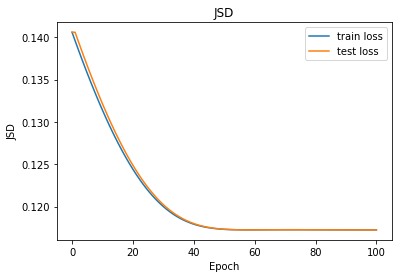

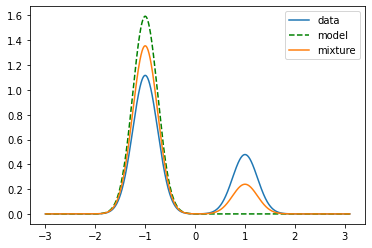

In [0]:
# random search over loc in [-1, 1], log_scale in [-1.5, 0]
n_itrs = 50
best = 1e9
best_params = None
jsd_model = Gaussian().to(ptu.device)
for i in range(n_itrs):
    jsd_model.loc.data = torch.rand(1).to(ptu.device) * 2 - 1 # [-1, 1]
    jsd_model.log_scale.data = torch.rand(1).to(ptu.device) * 1.5 - 1.5 # [-1.5, 0]
    jsd_loss = jsd(jsd_model, data_distribution)
    if jsd_loss < best:
        best = jsd_loss
        best_params = (jsd_model.loc.data, jsd_model.log_scale.data)

jsd_model.loc.data, jsd_model.log_scale.data = best_params
# fine tune with gradient descent
train_losses, test_losses = train_epochs(jsd_model, data_distribution, dict(lr=3E-3, epochs=100), loss_fn = jsd)
plot_losses(train_losses, test_losses, 'JSD', ylabel='JSD')
plot_jsd_model(jsd_model, data_distribution)

JSD seems to also be **mode-seeking**, like the reverse KL. Thus, a GAN optimized using the standard minimax objective may suffer from mode collapse if the model capacity is too low. 

## Summary plot:

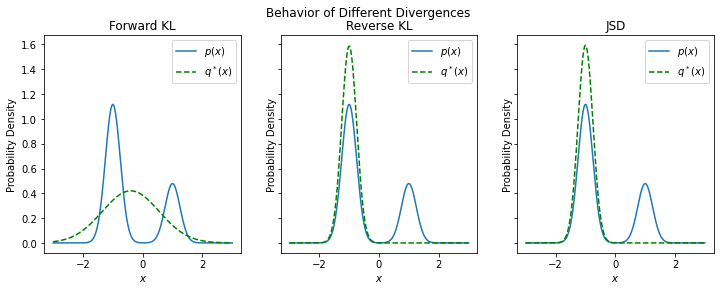

In [0]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4), sharey=True)
axs[0].plot(xs, ys, label='$p(x)$')
axs[0].plot(xs, mle_model.log_prob(torch.tensor(xs)).exp().detach().numpy(), c='g', linestyle='dashed', label='$q^*(x)$')
axs[0].legend()
axs[0].set_ylabel("Probability Density")
axs[0].set_xlabel("$x$")
axs[0].set_title('Forward KL')

axs[1].plot(xs, ys, label='$p(x)$')
axs[1].plot(xs, rkl_model.log_prob(torch.tensor(xs)).exp().detach().numpy(), c='g', linestyle='dashed', label='$q^*(x)$')
axs[1].legend()
axs[1].set_ylabel("Probability Density")
axs[1].set_xlabel("$x$")
axs[1].set_title('Reverse KL')

axs[2].plot(xs, ys, label='$p(x)$')
axs[2].plot(xs, jsd_model.log_prob(torch.tensor(xs)).exp().detach().numpy(), c='g', linestyle='dashed', label='$q^*(x)$')
axs[2].legend()
axs[2].set_ylabel("Probability Density")
axs[2].set_xlabel("$x$")
axs[2].set_title('JSD')

fig.suptitle('Behavior of Different Divergences')
# plt.tight_layout()
plt.show()


# Demo 2: Motivation for non-saturating GAN objective

The standard minimax objective is $$min_{G} max_{D} \mathbb{E}_{x \sim p_{data}} [\log D(x)] + \mathbb{E}_{z \sim p(z)}[\log (1-D(G(z)))]$$. The discriminator $D$ tries to assign a high score to real points $x$ and a low score to fake samples $G(z)$; conversely, the generator tries to generate samples that the discriminator thinks are real. 

However, this objective can sometimes be difficult to optimize in practice. The problem is that the discriminator $D$ can get too strong, after which the generator has little gradient signal that it can use to improve. The non-saturating objective can help fix this:
$$L^{(D)} = - \mathbb{E}_{x \sim p_{data}} [\log D(x)] - \mathbb{E}_{z \sim p(z)}[\log (1-D(G(z)))]$$
$$L^{(G} = - \mathbb{E}_{z \sim p(z)} \log(D(G(z))$$
Here, the discriminator tries to minimize $L^{(D)}$ and the generator tries to minimize $L^{(G)}$. We note that the discriminator objective hasn't actually changed, but the generator's objective has. Let's see why this might help. 

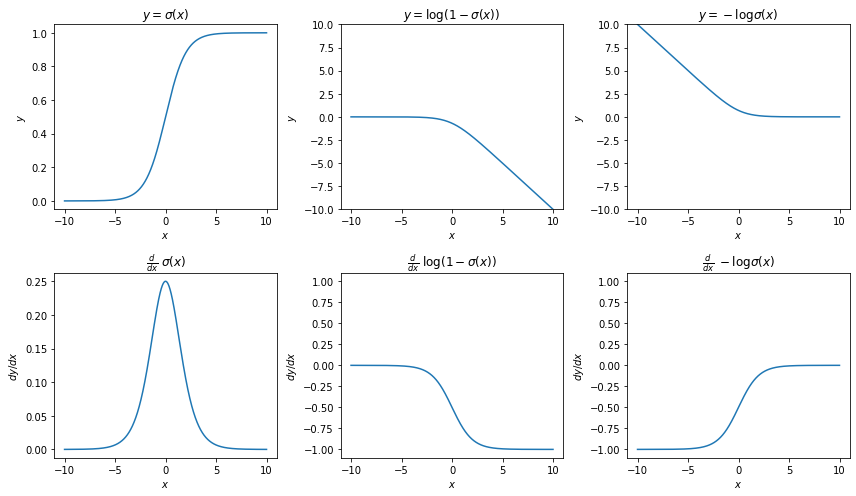

In [0]:
fig, axs = plt.subplots(2, 3, figsize=(12, 7), sharey=False) 
xs = np.linspace(-10, 10, num=10000)
xs_tensor = torch.tensor(xs)

axs[0,0].plot(xs, torch.sigmoid(xs_tensor).numpy())
axs[0,0].set_xlabel("$x$")
axs[0,0].set_ylabel("$y$")
axs[0,0].set_title('$y = \sigma(x)$')

axs[0,1].plot(xs, (1-torch.sigmoid(xs_tensor)).log().numpy())
axs[0,1].set_xlabel("$x$")
axs[0,1].set_ylabel("$y$")
axs[0,1].set_title('$y = \log (1- \sigma(x))$')
axs[0,1].set_ylim(-10.0, 10.0)

axs[0,2].plot(xs, - torch.sigmoid(xs_tensor).log().numpy())
axs[0,2].set_xlabel("$x$")
axs[0,2].set_ylabel("$y$")
axs[0,2].set_title('$y = -\log \sigma(x)$')
axs[0,2].set_ylim(-10.0, 10.0)

sigmoid_derivative = torch.sigmoid(xs_tensor) * (1 - torch.sigmoid(xs_tensor))
axs[1,0].plot(xs, sigmoid_derivative.numpy())
axs[1,0].set_xlabel("$x$")
axs[1,0].set_ylabel("$dy/dx$")
axs[1,0].set_title('$\\frac{d}{dx} \; \sigma(x)$')

derivative2 = - sigmoid_derivative / (1 - torch.sigmoid(xs_tensor))
axs[1,1].plot(xs, derivative2.numpy())
axs[1,1].set_xlabel("$x$")
axs[1,1].set_ylabel("$dy/dx$")
axs[1,1].set_title('$\\frac{d}{dx} \; \log (1- \sigma(x))$')
axs[1,1].set_ylim(-1.1, 1.1)

derivative3 = - sigmoid_derivative / torch.sigmoid(xs_tensor)
axs[1,2].plot(xs, derivative3.numpy())
axs[1,2].set_xlabel("$x$")
axs[1,2].set_ylabel("$dy/dx$")
axs[1,2].set_title('$\\frac{d}{dx} \; -\log \sigma(x)$')
axs[1,2].set_ylim(-1.1, 1.1)

plt.tight_layout()

**Column 1:**
In the first column, we show the sigmoid function (function on top, deriative on the bottom). We can think of $y$ as the output of the discriminator, and $x$ as what goes into the final sigmoid nonlinearity. For large $x$, the discriminator outputs a value near 1, which signals high model confidence that this is a real sample. Conversely, for negative $x$, the discriminator outputs something near 0 -- it thinks the input is fake. 

**Column 2:**
In the middle column, we show the function that the generator is trying to optimize in the standard minimax formulation. The plot of the derivative in the bottom row shows that there may be problems with trying to perform gradient descent on the objective. If the discriminator is too good, then $x$ is far to the left, the derivative vanishes to 0, and the generator doesn't learn. 

**Column 3:**
The rightmost column shows how the non-saturating objective can make it easier for the generator to learn. The top row is the new generator loss, and the bottom row is a plot of the derivative of that loss. Even if the discriminator is strong and $x$ is very negative, there's still a strong gradient signal (with magnitude $\approx 1$) that pushes the generator towards producing better samples. 

# Demo 3: GANs in 1D


## Dataset

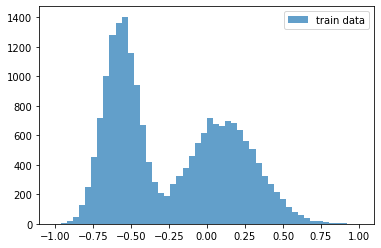

In [0]:
visualize_demo3_dataset()

## Minimax formulation:
In this part, we'll train our generator and discriminator via the original minimax GAN objective:
$$min_{G} max_{D} \mathbb{E}_{x \sim p_{data}} [\log D(x)] + \mathbb{E}_{z \sim p(z)}[\log (1-D(G(z)))]$$

We'll use an MLP for both your generator and your discriminator, and train until the generated distribution resembles the target distribution. 

### Training Code

In [0]:
def train(generator, critic, c_loss_fn, g_loss_fn, train_loader, g_optimizer, c_optimizer, n_critic=1, g_scheduler=None, c_scheduler=None, weight_clipping=None):
    """
    generator: 
    critic: discriminator in 1ab, general model otherwise
    loss_fn
    train_loader: instance of DataLoader class
    optimizer: 
    ncritic: how many critic gradient steps to do for every generator step
    """
    g_losses, c_losses = [], []
    generator.train()
    critic.train()
    for i, x in enumerate(train_loader):
        x = x.to(ptu.device).float()
        c_loss = c_loss_fn(generator, critic, x)
        c_optimizer.zero_grad()
        c_loss.backward()
        c_optimizer.step()
        c_losses.append(c_loss.item())
        if weight_clipping is not None:
            for param in critic.parameters():
                param.data.clamp_(-weight_clipping, weight_clipping)

        if i % n_critic == 0:  # generator step
            g_loss = g_loss_fn(generator, critic, x)
            g_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()
            g_losses.append(g_loss.item())
            if g_scheduler is not None:
                g_scheduler.step()
            if c_scheduler is not None:
                c_scheduler.step()
    return dict(g_losses=g_losses, c_losses=c_losses)

def train_epochs(generator, critic, g_loss_fn, c_loss_fn, train_loader, train_args):
    epochs, lr = train_args['epochs'], train_args['lr']
    if 'optim_cls' in train_args:
        g_optimizer = train_args['optim_cls'](generator.parameters(), lr=lr)
        c_optimizer = train_args['optim_cls'](critic.parameters(), lr=lr)
    else:
        g_optimizer = optim.Adam(generator.parameters(), lr=lr, betas=(0, 0.9))
        c_optimizer = optim.Adam(critic.parameters(), lr=lr, betas=(0, 0.9))
        
    if train_args.get('lr_schedule', None) is not None:
        g_scheduler = optim.lr_scheduler.LambdaLR(g_optimizer, train_args['lr_schedule'])
        c_scheduler = optim.lr_scheduler.LambdaLR(c_optimizer, train_args['lr_schedule'])
    else:
        g_scheduler = None
        c_scheduler = None 

    train_losses = dict()
    for epoch in tqdm_notebook(range(epochs), desc='Epoch', leave=False):
        if epoch == 1:
            epoch1_snapshot = get_training_snapshot(generator, critic)
        generator.train()
        critic.train()
        train_loss = train(generator, critic, c_loss_fn, g_loss_fn, train_loader, 
                           g_optimizer, c_optimizer, n_critic=train_args.get('n_critic', 0), 
                           g_scheduler=g_scheduler, c_scheduler=c_scheduler,
                           weight_clipping=train_args.get('weight_clipping', None))
        
        for k in train_loss.keys():
            if k not in train_losses:
                train_losses[k] = []
            train_losses[k].extend(train_loss[k])

    if train_args.get('q1', False):  # q1, return the snapshots
        final_snapshot = get_training_snapshot(generator, critic)
        return [train_losses, *epoch1_snapshot, *final_snapshot]
    else:
        return train_losses

def get_training_snapshot(generator, critic, n_samples=5000):
    generator.eval()
    critic.eval()
    xs = np.linspace(-1, 1, 1000)
    samples = ptu.get_numpy(generator.sample(n_samples))
    critic_output = ptu.get_numpy(critic(ptu.FloatTensor(xs).unsqueeze(1)))
    return samples, xs, critic_output

### Models


In [0]:
class MLP(nn.Module):
    def __init__(self, input_size, n_hidden, hidden_size, output_size):
        super().__init__()
        layers = []
        for _ in range(n_hidden):
            layers.append(nn.Linear(input_size, hidden_size))
            layers.append(nn.LeakyReLU(0.2))
            input_size = hidden_size
        layers.append(nn.Linear(hidden_size, output_size))
        self.layers = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.layers(x)

class MLPGenerator(nn.Module):
    def __init__(self, latent_dim, n_hidden, hidden_size, data_dim):
        super().__init__()
        layers = []
        self.latent_dim = latent_dim
        self.mlp = MLP(latent_dim, n_hidden, hidden_size, data_dim)
        # self.log_scale = nn.Parameter(torch.zeros(data_dim), requires_grad=True)
    
    def forward(self, z):
        return torch.tanh(self.mlp(z)) # * self.log_scale.exp()
        return self.mlp(z) # * self.log_scale.exp()
        
    def sample(self, n):
        # n is the number of samples to return
        z = ptu.normal(ptu.zeros(n, self.latent_dim), ptu.ones(n, self.latent_dim))
        return self.forward(z)

class MLPDiscriminator(nn.Module):
    def __init__(self, latent_dim, n_hidden, hidden_size, data_dim):
        super().__init__()
        self.mlp = MLP(latent_dim, n_hidden, hidden_size, data_dim)
    
    def forward(self, z):
        return torch.sigmoid(self.mlp(z)) 

In [0]:
ptu.set_gpu_mode(True)  # use GPU

def demo3_a(train_data):
    # create data loaders
    loader_args = dict(batch_size=64, shuffle=True)
    train_loader = data.DataLoader(train_data, **loader_args)

    # model
    g = MLPGenerator(1, 3, 128, 1).to(ptu.device)
    c = MLPDiscriminator(1, 3, 128, 1).to(ptu.device)

    # loss functions
    def g_loss(generator, critic, x):
        fake_data = generator.sample(x.shape[0])
        return (1 - critic(fake_data)).log().mean()

    def c_loss(generator, critic, x):
        fake_data = generator.sample(x.shape[0])
        return - (1 - critic(fake_data)).log().mean() - critic(x).log().mean()

    # train
    train_losses, samples_1, xs_1, critic_1, samples_final, xs_final, critic_final = train_epochs(g, c, g_loss, c_loss, train_loader, dict(epochs=25, lr=1e-4, n_critic=2, q1=True))

    return train_losses['c_losses'], samples_1, xs_1, critic_1, samples_final, xs_final, critic_final

### Results

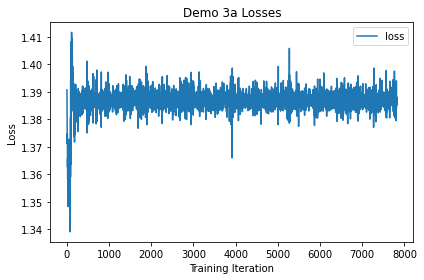

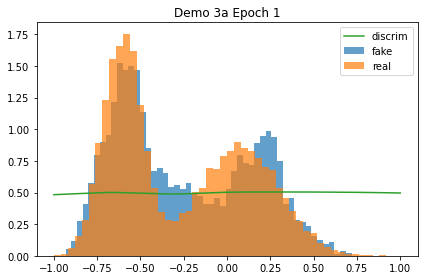

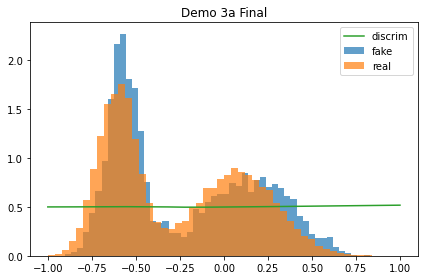

In [0]:
demo3_save_results('a', demo3_a)

## Non-saturating formulation:
Here, we'll use the non-saturating formulation, where the generator and discriminator no longer maximize and minimize the same terms. Now, we have:
$$L^{(D)} = -\mathbb{E}_{x \sim p_{data}} [\log D(x)] - \mathbb{E}_{z \sim p(z)}[\log (1-D(G(z)))]$$
$$L^{(G} = - \mathbb{E}_{z \sim p(z)} \log(D(G(z))$$

### New training code:

In [0]:
def demo3_b(train_data):
    # create data loaders
    loader_args = dict(batch_size=64, shuffle=True)
    train_loader = data.DataLoader(train_data, **loader_args)

    # model
    g = MLPGenerator(1, 3, 128, 1).to(ptu.device)
    c = MLPDiscriminator(1, 3, 128, 1).to(ptu.device)

    # loss functions
    def g_loss(generator, critic, x):
        fake_data = generator.sample(x.shape[0])
        return - critic(fake_data).log().mean()

    def c_loss(generator, critic, x):
        fake_data = generator.sample(x.shape[0])
        return  - (1 - critic(fake_data)).log().mean() - critic(x).log().mean()

    # train
    train_losses, samples_1, xs_1, critic_1, samples_final, xs_final, critic_final = train_epochs(g, c, g_loss, c_loss, train_loader, dict(epochs=25, lr=1e-4, n_critic=2, q1=True))

    return train_losses['c_losses'], samples_1, xs_1, critic_1, samples_final, xs_final, critic_final

### Results

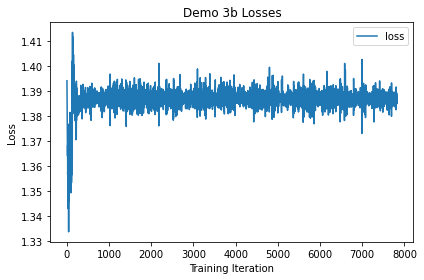

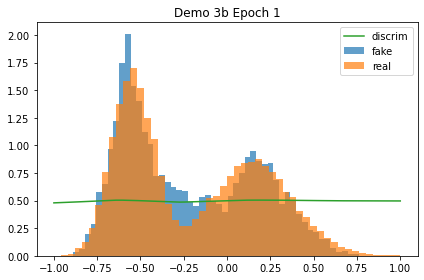

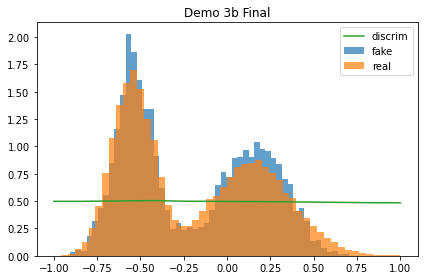

In [0]:
demo3_save_results('b', demo3_b)

# Demo 4: WGAN-GP on CIFAR 10
In this demo, we'll train a WGAN-GP on CIFAR-10. Let's visualize what the dataset looks like.


## Dataset

Files already downloaded and verified


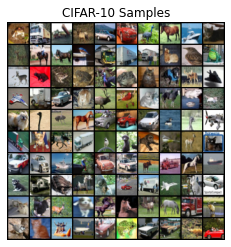

In [0]:
visualize_demo4_data()

## Models
We'll use the CIFAR-10 architecture from the [SN-GAN paper](https://arxiv.org/pdf/1802.05957.pdf), with $z \in \mathbb R ^{128}$, with $z \sim \mathcal N (0, I_{128})$. Instead of upsampling via transposed convolutions and downsampling via pooling or striding, we'll use DepthToSpace and SpaceToDepth methods for changing the spatial configuration of our hidden states. We'll implement [WGAN-GP](https://arxiv.org/abs/1704.00028), which uses a gradient penalty to regularize the discriminator. We use the Adam optimizer with $\alpha = 2e-4$, $\beta_1 = 0$, $\beta_2 = 0.9$, $\lambda = 10$, $n_{critic} = 5$. We use a batch size of 256 and n_filters=128 within the ResBlocks, and train for at least 25000 gradient steps, with the learning rate linearly annealed to 0 over training. 

In [0]:
class DepthToSpace(nn.Module):
    def __init__(self, block_size):
        super(DepthToSpace, self).__init__()
        self.block_size = block_size
        self.block_size_sq = block_size * block_size

    def forward(self, input):
        output = input.permute(0, 2, 3, 1)
        (batch_size, d_height, d_width, d_depth) = output.size()
        s_depth = int(d_depth / self.block_size_sq)
        s_width = int(d_width * self.block_size)
        s_height = int(d_height * self.block_size)
        t_1 = output.reshape(batch_size, d_height, d_width, self.block_size_sq, s_depth)
        spl = t_1.split(self.block_size, 3)
        stack = [t_t.reshape(batch_size, d_height, s_width, s_depth) for t_t in spl]
        output = torch.stack(stack, 0).transpose(0, 1).permute(0, 2, 1, 3, 4).reshape(batch_size, s_height, s_width,
                                                                                      s_depth)
        output = output.permute(0, 3, 1, 2)
        return output.contiguous()


class SpaceToDepth(nn.Module):
    def __init__(self, block_size):
        super(SpaceToDepth, self).__init__()
        self.block_size = block_size
        self.block_size_sq = block_size * block_size

    def forward(self, input):
        output = input.permute(0, 2, 3, 1)
        (batch_size, s_height, s_width, s_depth) = output.size()
        d_depth = s_depth * self.block_size_sq
        d_width = int(s_width / self.block_size)
        d_height = int(s_height / self.block_size)
        t_1 = output.split(self.block_size, 2)
        stack = [t_t.reshape(batch_size, d_height, d_depth) for t_t in t_1]
        output = torch.stack(stack, 1)
        output = output.permute(0, 2, 1, 3)
        output = output.permute(0, 3, 1, 2)
        return output.contiguous()


class Upsample_Conv2d(nn.Module):
    def __init__(self, in_dim, out_dim, kernel_size=(3, 3), stride=1, padding=1, bias=True):
        super(Upsample_Conv2d, self).__init__()
        self.conv = nn.Conv2d(in_dim, out_dim, kernel_size,
                              stride=stride, padding=padding, bias=bias)
        self.depth_to_space = DepthToSpace(2)

    def forward(self, x):
        _x = torch.cat([x, x, x, x], dim=1)
        _x = self.depth_to_space(_x)
        _x = self.conv(_x)
        return _x


class Downsample_Conv2d(nn.Module):
    def __init__(self, in_dim, out_dim, kernel_size=(3, 3), stride=1, padding=1, bias=True):
        super(Downsample_Conv2d, self).__init__()
        self.conv = nn.Conv2d(in_dim, out_dim, kernel_size,
                              stride=stride, padding=padding, bias=bias)
        self.space_to_depth = SpaceToDepth(2)

    def forward(self, x):
        _x = self.space_to_depth(x)
        _x = sum(_x.chunk(4, dim=1)) / 4.0
        _x = self.conv(_x)
        return _x


class ResnetBlockUp(nn.Module):
    def __init__(self, in_dim, kernel_size=(3, 3), n_filters=256):
        super(ResnetBlockUp, self).__init__()
        self.layers = nn.ModuleList([
            nn.BatchNorm2d(in_dim),
            nn.ReLU(),
            nn.Conv2d(in_dim, n_filters, kernel_size, padding=1),
            nn.BatchNorm2d(n_filters),
            nn.ReLU(),
            Upsample_Conv2d(n_filters, n_filters, kernel_size, padding=1),
            Upsample_Conv2d(in_dim, n_filters, kernel_size=(1, 1), padding=0)
        ])

    def forward(self, x):
        _x = x
        for i in range(len(self.layers) - 1):
            _x = self.layers[i](_x)
        return self.layers[-1](x) + _x


class ResnetBlockDown(nn.Module):
    def __init__(self, in_dim, kernel_size=(3, 3), stride=1, n_filters=256):
        super(ResnetBlockDown, self).__init__()
        self.layers = nn.ModuleList([
            nn.ReLU(),
            nn.Conv2d(in_dim, n_filters, kernel_size, stride=stride, padding=1),
            nn.ReLU(),
            Downsample_Conv2d(n_filters, n_filters, kernel_size),
            Downsample_Conv2d(in_dim, n_filters, kernel_size=(1, 1), padding=0)
        ])

    def forward(self, x):
        _x = x
        for i in range(len(self.layers) - 1):
            _x = self.layers[i](_x)
        return self.layers[-1](x) + _x


class ResBlock(nn.Module):
    def __init__(self, in_dim, kernel_size=(3, 3), n_filters=256):
        super(ResBlock, self).__init__()
        self.layers = nn.ModuleList([
            nn.ReLU(),
            nn.Conv2d(in_dim, n_filters, kernel_size, padding=1),
            nn.ReLU(),
            nn.Conv2d(n_filters, n_filters, kernel_size, padding=1)
        ])

    def forward(self, x):
        _x = x
        for op in self.layers:
            _x = op(_x)
        return x + _x


class Generator(nn.Module):
    def __init__(self, n_filters=256):
        super(Generator, self).__init__()
        self.fc = nn.Linear(128, 4 * 4 * 256)
        network = [
            ResnetBlockUp(in_dim=256, n_filters=n_filters),
            ResnetBlockUp(in_dim=n_filters, n_filters=n_filters),
            ResnetBlockUp(in_dim=n_filters, n_filters=n_filters),
            nn.BatchNorm2d(n_filters),
            nn.ReLU(),
            nn.Conv2d(n_filters, 3, kernel_size=(3, 3), padding=1),
            nn.Tanh()
        ]
        self.net = nn.Sequential(*network)
        self.noise = torch.distributions.Normal(torch.tensor(0.), torch.tensor(1.))

    def forward(self, z):
        z = self.fc(z).reshape(-1, 256, 4, 4)
        return self.net(z)

    def sample(self, n_samples):
        z = self.noise.sample([n_samples, 128]).to(ptu.device)
        return self.forward(z)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.fc = nn.Linear(128, 4 * 4 * 256)
        network = [
            ResnetBlockDown(3, n_filters=128),
            ResnetBlockDown(128, n_filters=128),
            ResBlock(128, n_filters=128),
            ResBlock(128, n_filters=128),
            nn.ReLU()
        ]
        self.net = nn.Sequential(*network)
        self.fc = nn.Linear(128, 1)

    def forward(self, z):
        z = self.net(z)
        z = torch.sum(z, dim=(2, 3))
        return self.fc(z)

## Training Code

In [0]:
class Solver(object):
    def __init__(self, train_data, n_iterations=50000, batch_size=256, n_filters=128):
        self.n_critic = 5
        self.log_interval = 100
        self.batch_size = batch_size
        self.n_filters = n_filters
        self.train_loader = self.create_loaders(train_data)
        self.n_batches_in_epoch = len(self.train_loader)
        self.n_epochs = self.n_critic * n_iterations // self.n_batches_in_epoch
        self.curr_itr = 0

    def build(self, part_name):
        self.g = Generator(n_filters=self.n_filters).to(ptu.device)
        self.d = Discriminator().to(ptu.device)
        self.g_optimizer = torch.optim.Adam(self.g.parameters(), lr=2e-4, betas=(0, 0.9))
        self.g_scheduler = torch.optim.lr_scheduler.LambdaLR(self.g_optimizer,
                                                             lambda epoch: (self.n_epochs - epoch) / self.n_epochs,
                                                             last_epoch=-1)
        self.d_optimizer = torch.optim.Adam(self.d.parameters(), lr=2e-4, betas=(0, 0.9))
        self.d_scheduler = torch.optim.lr_scheduler.LambdaLR(self.d_optimizer,
                                                             lambda epoch: (self.n_epochs - epoch) / self.n_epochs,
                                                             last_epoch=-1)
        self.part_name = part_name

    def create_loaders(self, train_data):
        train_loader = data.DataLoader(train_data, batch_size=self.batch_size, shuffle=True)
        return train_loader

    def gradient_penalty(self, real_data, fake_data):
        batch_size = real_data.shape[0]

        # Calculate interpolation
        eps = torch.rand(batch_size, 1, 1, 1).to(ptu.device)
        eps = eps.expand_as(real_data)
        interpolated = eps * real_data.data + (1 - eps) * fake_data.data
        interpolated.requires_grad = True

        d_output = self.d(interpolated)
        gradients = torch.autograd.grad(outputs=d_output, inputs=interpolated,
                                        grad_outputs=torch.ones(d_output.size()).to(ptu.device),
                                        create_graph=True, retain_graph=True)[0]

        gradients = gradients.reshape(batch_size, -1)
        gradients_norm = torch.sqrt(torch.sum(gradients ** 2, dim=1) + 1e-12)
        return ((gradients_norm - 1) ** 2).mean()

    def train(self):
        train_losses = []
        for epoch_i in tqdm_notebook(range(self.n_epochs), desc='Epoch', leave=False):
            epoch_i += 1

            self.d.train()
            self.g.train()
            self.batch_loss_history = []

            for batch_i, x in enumerate(tqdm_notebook(self.train_loader, desc='Batch', leave=False)):
                batch_i += 1
                self.curr_itr += 1
                x = ptu.tensor(x).float()
                x = 2 * (x - 0.5)

                # do a critic update
                self.d_optimizer.zero_grad()
                fake_data = self.g.sample(x.shape[0])
                gp = self.gradient_penalty(x, fake_data)
                d_loss = self.d(fake_data).mean() - self.d(x).mean() + 10 * gp
                d_loss.backward()
                self.d_optimizer.step()
                # generator update
                if self.curr_itr % self.n_critic == 0:
                    self.g_optimizer.zero_grad()
                    fake_data = self.g.sample(self.batch_size)
                    g_loss = -self.d(fake_data).mean()
                    g_loss.backward()
                    self.g_optimizer.step()

                    # step the learning rate
                    self.g_scheduler.step()
                    self.d_scheduler.step()

                    self.batch_loss_history.append(g_loss.data.cpu().numpy())

            epoch_loss = np.mean(self.batch_loss_history)
            train_losses.append(epoch_loss)
            np.save("q2_train_losses.npy", np.array(train_losses))

        train_losses = np.array(train_losses)
        self.save_model(f"{self.part_name}.pt")
        return train_losses

    def sample_for_eval(self, n_samples):
        self.g.eval()
        output = [] 
        with torch.no_grad():
            for i in range(n_samples//250):
                output.append(ptu.get_numpy(self.g.sample(250)))
        return np.concatenate(output, axis=0)

    def save_model(self, filename):
        split_path = list(osp.split(filename))
        g_path = osp.join(*split_path[:-1], 'g_' + split_path[-1])
        d_path = osp.join(*split_path[:-1], 'd_' + split_path[-1])
        torch.save(self.g.state_dict(), g_path)
        torch.save(self.d.state_dict(), d_path)

    def load_model(self, filename):
        split_path = list(osp.split(filename))
        g_path = osp.join(*split_path[:-1], 'g_' + split_path[-1])
        d_path = osp.join(*split_path[:-1], 'd_' + split_path[-1])
        self.d.load_state_dict(torch.load(d_path))
        self.g.load_state_dict(torch.load(g_path))


In [0]:
def demo4(train_data, model_path=None, losses_path=None):
    solver = Solver(train_data, n_iterations=50000)
    solver.build("wgan")
    if model_path is not None and losses_path is not None:
        solver.load_model(model_path)
        losses = np.load(losses_path)
    else:
        losses = solver.train()
    solver.g.eval()
    solver.d.eval()
    with torch.no_grad():
        samples = solver.g.sample(1000)
        samples = ptu.get_numpy(samples.permute(0, 2, 3, 1)) * 0.5 + 0.5

    return losses, samples

## Results

Files already downloaded and verified


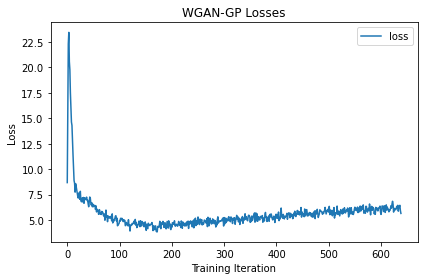

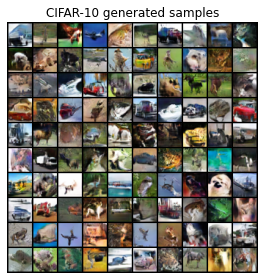

In [0]:
# to load our pretrained models
demo4_fn = lambda x: demo4(x, model_path='pretrained_models/wgan.pt', losses_path='pretrained_models/wgan_losses.npy')

# uncomment following line if you want to train from scratch (will take a few hours)
# demo4_fn = demo4

demo4_save_results(demo4_fn)

# Demo 5: Evaluating samples with the Inception Score
We need some quantitative metric for evaluating the quality of the samples that we generate with GANs. For autoregressive models and flows we had the exact negative log-likelihood, and for VAEs we had the ELBO, but implicit models like GANs have no such metric. There have been a variety of approaches for doing density estimation with GANs, but methods such as Parzen window estimation [have been shown](https://arxiv.org/abs/1511.01844) to be extremely inaccurate. Instead of focusing on obtaining density estimates, maybe we should focus directly on the characteristics that we intuitively want our samples to have.  

The Inception Score is a method developed to capture two main desirables:
- Samples should be diverse (model should attempt to cover the main modes of the data distribution. 
- Samples should be perceptually clear. We can say that we want a learned classifier p(y|x) to give high probability to a single class $y$ for each sample $x$. 

The Inception Score is calculated this way: 
$$IS = \exp\{\mathbb{E}_{x \sim p_g}[D_{KL}(p(y|x)||p(y)]\}$$
where $p(y|x)$ is estimated via a pretrained [Inception classifier](https://arxiv.org/abs/1512.00567). This comes out to be equivalent to
$$IS = \exp\{H(Y) - H(Y|X)\}$$
High inception score means that $H(Y)$ is high (high diversity of samples), while $H(Y|X)$ is low (each image clearly corresponds to some realistic object).

## Model: Inception classifier

In [0]:
class Inception(nn.Module):
    def __init__(self, in_planes, kernel_1_x, kernel_3_in, kernel_3_x, kernel_5_in, kernel_5_x, pool_planes):
        super(Inception, self).__init__()
        # 1x1 conv branch
        self.b1 = nn.Sequential(
            nn.Conv2d(in_planes, kernel_1_x, kernel_size=1),
            nn.BatchNorm2d(kernel_1_x),
            nn.ReLU(True),
        )

        # 1x1 conv -> 3x3 conv branch
        self.b2 = nn.Sequential(
            nn.Conv2d(in_planes, kernel_3_in, kernel_size=1),
            nn.BatchNorm2d(kernel_3_in),
            nn.ReLU(True),
            nn.Conv2d(kernel_3_in, kernel_3_x, kernel_size=3, padding=1),
            nn.BatchNorm2d(kernel_3_x),
            nn.ReLU(True),
        )

        # 1x1 conv -> 5x5 conv branch
        self.b3 = nn.Sequential(
            nn.Conv2d(in_planes, kernel_5_in, kernel_size=1),
            nn.BatchNorm2d(kernel_5_in),
            nn.ReLU(True),
            nn.Conv2d(kernel_5_in, kernel_5_x, kernel_size=3, padding=1),
            nn.BatchNorm2d(kernel_5_x),
            nn.ReLU(True),
            nn.Conv2d(kernel_5_x, kernel_5_x, kernel_size=3, padding=1),
            nn.BatchNorm2d(kernel_5_x),
            nn.ReLU(True),
        )

        # 3x3 pool -> 1x1 conv branch
        self.b4 = nn.Sequential(
            nn.MaxPool2d(3, stride=1, padding=1),
            nn.Conv2d(in_planes, pool_planes, kernel_size=1),
            nn.BatchNorm2d(pool_planes),
            nn.ReLU(True),
        )

    def forward(self, x):
        y1 = self.b1(x)
        y2 = self.b2(x)
        y3 = self.b3(x)
        y4 = self.b4(x)
        return torch.cat([y1,y2,y3,y4], 1)


class GoogLeNet(nn.Module):
    def __init__(self):
        super(GoogLeNet, self).__init__()
        self.pre_layers = nn.Sequential(
            nn.Conv2d(3, 192, kernel_size=3, padding=1),
            nn.BatchNorm2d(192),
            nn.ReLU(True),
        )

        self.a3 = Inception(192,  64,  96, 128, 16, 32, 32)
        self.b3 = Inception(256, 128, 128, 192, 32, 96, 64)

        self.max_pool = nn.MaxPool2d(3, stride=2, padding=1)

        self.a4 = Inception(480, 192,  96, 208, 16,  48,  64)
        self.b4 = Inception(512, 160, 112, 224, 24,  64,  64)
        self.c4 = Inception(512, 128, 128, 256, 24,  64,  64)
        self.d4 = Inception(512, 112, 144, 288, 32,  64,  64)
        self.e4 = Inception(528, 256, 160, 320, 32, 128, 128)

        self.a5 = Inception(832, 256, 160, 320, 32, 128, 128)
        self.b5 = Inception(832, 384, 192, 384, 48, 128, 128)

        self.avgpool = nn.AvgPool2d(8, stride=1)
        self.linear = nn.Linear(1024, 10)

    def forward(self, x):
        x = self.pre_layers(x)
        x = self.a3(x)
        x = self.b3(x)
        x = self.max_pool(x)
        x = self.a4(x)
        x = self.b4(x)
        x = self.c4(x)
        x = self.d4(x)
        x = self.e4(x)
        x = self.max_pool(x)
        x = self.a5(x)
        x = self.b5(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        return x

    def forward_fid(self, x):
        x = self.pre_layers(x)
        x = self.a3(x)
        x = self.b3(x)
        x = self.max_pool(x)
        x = self.a4(x)
        x = self.b4(x)
        x = self.c4(x)
        x = self.d4(x)
        x = self.e4(x)
        x = self.max_pool(x)
        x = self.a5(x)
        x = self.b5(x)
        x = self.avgpool(x)
        return x

## Inception score calculation:

In [0]:
def calculate_is(samples):
    model = GoogLeNet().to(ptu.device)
    model.load_state_dict(torch.load("deepul/deepul/hw4_utils/classifier.pt"))
    softmax = nn.Sequential(model, nn.Softmax(dim=1))

    bs = 100
    softmax.eval()
    with torch.no_grad():
        preds = []
        n_batches = int(math.ceil(float(len(samples)) / float(bs)))
        for i in range(n_batches):
            inp = ptu.FloatTensor(samples[(i * bs):min((i + 1) * bs, len(samples))])
            pred = ptu.get_numpy(softmax(inp))
            preds.append(pred)
    preds = np.concatenate(preds, 0)
    kl = preds * (np.log(preds) - np.log(np.expand_dims(np.mean(preds, 0), 0)))
    kl = np.mean(np.sum(kl, 1))
    return np.exp(kl)

## Results

Files already downloaded and verified


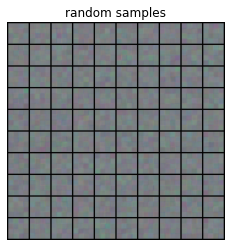

Inception score: 1.1896409


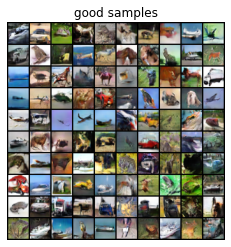

Inception score: 8.06386


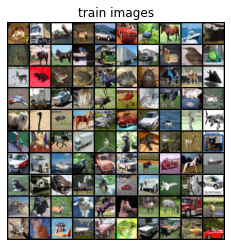

Inception score: 9.991419


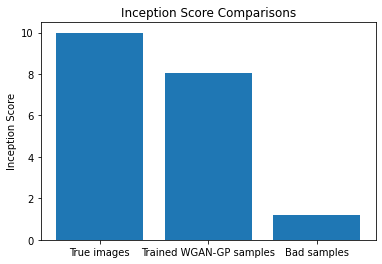

In [0]:
ptu.set_gpu_mode(True)

# real images from the train set
train_images = load_q2_data()
train_images_to_eval = np.array(train_images.data[:5000]) / 255.0

# samples from randomly initialized generator
solver = Solver(train_images)
solver.build('wgan')
bad_samples = solver.sample_for_eval(5000).transpose([0, 2, 3, 1]) * 0.5 + 0.5


# samples from WGAN-GP trained in Demo 4
solver.load_model('pretrained_models/wgan.pt')
good_samples = solver.sample_for_eval(5000).transpose([0, 2, 3, 1]) * 0.5 + 0.5

# calculate IS
bad_is = calculate_is(bad_samples.transpose([0, 3, 1, 2]))
good_is = calculate_is(good_samples.transpose([0, 3, 1, 2]))
real_is = calculate_is(train_images_to_eval.transpose([0, 3, 1, 2]))

# display images
show_samples(bad_samples[:100] * 255.0, title='random samples')
print("Inception score:", bad_is)
show_samples(good_samples[:100] * 255.0, title='good samples')
print("Inception score:", good_is)
show_samples(train_images.data[:100], title='train images')
print("Inception score:", real_is)

# bar plot
plt.bar(['True images', 'Trained WGAN-GP samples', 'Bad samples'], [real_is, good_is, bad_is])
plt.title("Inception Score Comparisons")
plt.ylabel("Inception Score")
plt.show()

# Demo 6: Evaluating samples with the Fréchet Inception Distance

While the Inception Score was a step forwards in terms of roughly correlating with human qualitative descriptions of visual sample quality, it had its shortcomings. It couched everything in terms of the predicted label $p(y|x)$, which isn't that informative. 

The Fréchet Inception Distance (FID) instead draws on the idea that samples should have the same first and second moments as the data distribution in some learned feature space. We use the Inception-v3 pool3 layer activations, since they should correspond to high-level perceptual characteristics. The FID can be calculated:
$$ FID = ||\mu_g - \mu_r||_2^2 + Tr(\Sigma_r + \Sigma_g - 2(\Sigma_r \Sigma_g)^{1/2})$$
where $\mu_r$ and $\mu_g$ are the means of the real and generated samples, respectively, and $\Sigma_r$ and $\Sigma_g$ are the covariances. This quantity represents the Wasserstein-2 distance (also called the Fréchet distance) between the two multivariate Gaussians fit to the pool3 activations of the data. Empirically, the FID correlates with human estimates of perceptual quality better than the IS does. 

## Fréchet Inception Distance calculation:

In [0]:
from scipy.linalg import sqrtm

def calculate_fid_stats(samples):
    model = GoogLeNet().to(ptu.device)
    model.load_state_dict(torch.load("deepul/deepul/hw4_utils/classifier.pt"))

    bs = 100
    softmax.eval()
    with torch.no_grad():
        features = []
        n_batches = int(math.ceil(float(len(samples)) / float(bs)))
        for i in range(n_batches):
            inp = ptu.FloatTensor(samples[(i * bs):min((i + 1) * bs, len(samples))])
            feature = ptu.get_numpy(model.forward_fid(inp))
            features.append(np.squeeze(feature))
    features = np.concatenate(features, 0)
    mean = np.mean(features, axis=0)
    cov = np.cov(features, rowvar=False)
    return mean, cov

def calculate_fid(real, samples):
    mean_real, cov_real = calculate_fid_stats(real)
    mean_samples, cov_samples = calculate_fid_stats(samples)

    return np.sum((mean_real - mean_samples)**2) + \
           np.trace(cov_real + cov_samples - 2.0 * sqrtm(cov_real.dot(cov_samples)))


## Results

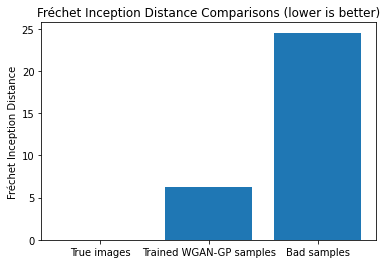

In [0]:
# calculate FID
bad_fid = calculate_fid(train_images_to_eval.transpose([0, 3, 1, 2]), bad_samples.transpose([0, 3, 1, 2]))
good_fid = calculate_fid(train_images_to_eval.transpose([0, 3, 1, 2]), good_samples.transpose([0, 3, 1, 2]))

# bar plot
plt.bar(['True images', 'Trained WGAN-GP samples', 'Bad samples'], [0, good_fid, bad_fid])
plt.title("Fréchet Inception Distance Comparisons (lower is better)")
plt.ylabel("Fréchet Inception Distance")
plt.show()

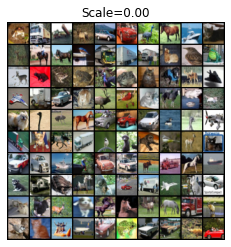

With scale=0.00: FID=-0.00, IS=9.99


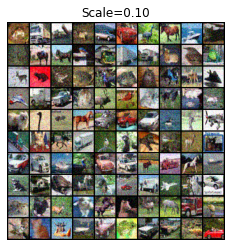

With scale=0.10: FID=5.08, IS=2.72


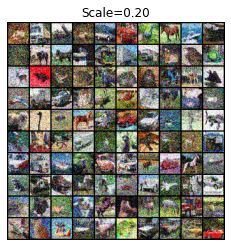

With scale=0.20: FID=12.64, IS=1.37


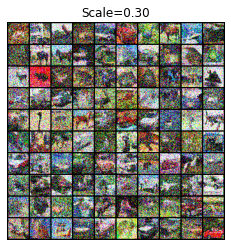

With scale=0.30: FID=17.11, IS=1.15


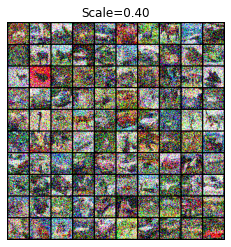

With scale=0.40: FID=20.22, IS=1.13


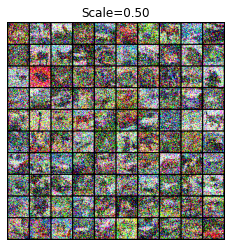

With scale=0.50: FID=21.79, IS=1.24


In [0]:
# testing the effect of varying levels of white noise on IS and FID metrics
scales = [0, 0.1, 0.2, 0.3, 0.4, 0.5]
inception_scores = []
fids = []
train_imgs = train_images_to_eval.transpose([0, 3, 1, 2])
for scale in scales:
    noisy_train_images_to_eval = np.clip(train_imgs + np.random.normal(scale=scale, size=train_imgs.shape), 0.0, 1.0)
    show_samples(noisy_train_images_to_eval[:100].transpose([0, 2, 3, 1]) * 255.0, title='Scale={:.2f}'.format(scale))
    fids.append(calculate_fid(train_imgs, noisy_train_images_to_eval))
    inception_scores.append(calculate_is(noisy_train_images_to_eval))
    print("With scale={:.2f}: FID={:.2f}, IS={:.2f}".format(scale, fids[-1], inception_scores[-1]))

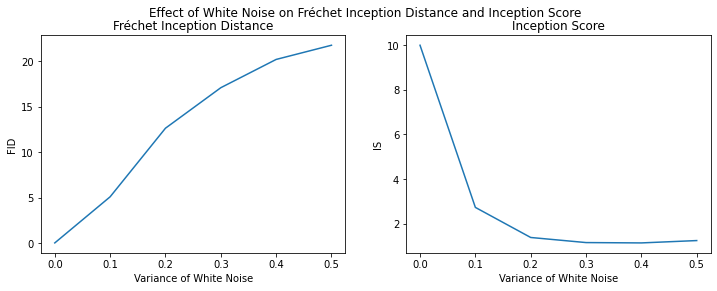

In [0]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharey=False)
axs[0].plot(scales, fids)
axs[0].set_ylabel("FID")
axs[0].set_xlabel("Variance of White Noise")
axs[0].set_title('Fréchet Inception Distance')

axs[1].plot(scales, inception_scores)
axs[1].set_ylabel("IS")
axs[1].set_xlabel("Variance of White Noise")
axs[1].set_title('Inception Score')

fig.suptitle('Effect of White Noise on Fréchet Inception Distance and Inception Score')
plt.show()

The FID is much more informative about the quality of samples. Looking at the figure on the right, the Inception Score quickly drops once any noise is added, bottoming out near 1. In contrast, the Fréchet Inception Distance gradually gets worse as more noise is added, giving us a much better sense of the sample quality. 

# Demo 7: Representation learning with BiGAN

## Models

In [0]:
class Generator(nn.Module):
    def __init__(self, g_input_dim, g_output_dim):
        super(Generator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(g_input_dim, 1024),
            nn.ReLU(),
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024, affine=False),
            nn.ReLU(),
            nn.Linear(1024, 784),
            nn.Tanh()
        )

    def forward(self, x):
        return self.fc(x).reshape(x.shape[0], 1, 28, 28)

class Discriminator(nn.Module):
    def __init__(self, z_dim, x_dim):
        super(Discriminator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(z_dim + x_dim, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024, affine=False),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 1),
            nn.Sigmoid()
        )

    def forward(self, z, x):
        x = torch.cat((z, x), dim=1)
        return self.fc(x)

class Encoder(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Encoder, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024, affine=False),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, output_dim),
        )

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        return self.fc(x)

## Training Code

In [0]:
from torchvision.utils import save_image

class Solver(object):
    def __init__(self, train_data, test_data, n_epochs=100, batch_size=128, latent_dim=50):
        self.log_interval = 100
        self.batch_size = batch_size
        self.train_loader, self.test_loader = self.create_loaders(train_data, test_data)
        self.n_batches_in_epoch = len(self.train_loader)
        self.n_epochs = n_epochs
        self.curr_itr = 0
        self.latent_dim = latent_dim

    def build(self):
        # BiGAN 
        self.d = Discriminator(self.latent_dim, 784).to(ptu.device)
        self.e = Encoder(784, self.latent_dim).to(ptu.device) 
        self.g = Generator(self.latent_dim, 784).to(ptu.device)  
        self.d_optimizer = torch.optim.Adam(self.d.parameters(), lr=2e-4, betas=(0.5, 0.999), weight_decay=2.5e-5)
        self.g_optimizer = torch.optim.Adam(list(self.e.parameters()) + list(self.g.parameters()), lr=2e-4, betas=(0.5, 0.999), weight_decay=2.5e-5)
        self.g_scheduler = torch.optim.lr_scheduler.LambdaLR(self.g_optimizer,
                                                             lambda epoch: (self.n_epochs - epoch) / self.n_epochs,
                                                             last_epoch=-1)
        self.d_optimizer = torch.optim.Adam(self.d.parameters(), lr=2e-4, betas=(0, 0.9))
        self.d_scheduler = torch.optim.lr_scheduler.LambdaLR(self.d_optimizer,
                                                             lambda epoch: (self.n_epochs - epoch) / self.n_epochs,
                                                             last_epoch=-1)
        
        # linear classifier 
        self.linear = nn.Linear(self.latent_dim, 10).to(device)
        self.linear_optimizer = torch.optim.Adam(self.linear.parameters(), lr=1e-3)

    def reset_linear(self):
        self.linear = nn.Linear(self.latent_dim, 10).to(device)
        self.linear_optimizer = torch.optim.Adam(self.linear.parameters(), lr=1e-3)

    def create_loaders(self, train_data, test_data):
        train_loader = torch.utils.data.DataLoader(train_data, batch_size=self.batch_size, shuffle=True)
        test_loader = torch.utils.data.DataLoader(test_data, batch_size=self.batch_size, shuffle=False)

        return train_loader, test_loader

    def get_discriminator_loss(self, x):
        z_fake = torch.normal(torch.zeros(x.shape[0], self.latent_dim), torch.ones(x.shape[0], self.latent_dim)).to(device)
        z_real = self.e(x).reshape(x.shape[0], self.latent_dim)
        x_fake = self.g(z_fake).reshape(x.shape[0], -1)
        x_real = x.view(x.shape[0], -1)

        d_loss = - 0.5 * (self.d(z_real, x_real)).log().mean() - 0.5 * (1 - self.d(z_fake, x_fake)).log().mean()
        return d_loss


    def train_bigan(self):
        train_losses = []
        val_losses = []
        for epoch_i in tqdm_notebook(range(self.n_epochs), desc='Epoch'):
            epoch_i += 1

            self.d.train()
            self.g.train()
            self.e.train()
            self.batch_loss_history = []

            for batch_i, (x, y) in enumerate(tqdm_notebook(self.train_loader, desc='Batch', leave=False)):
                batch_i += 1
                self.curr_itr += 1
                x = x.to(ptu.device).float()

                # do a minibatch update
                self.d_optimizer.zero_grad()
                d_loss = self.get_discriminator_loss(x)
                d_loss.backward()
                self.d_optimizer.step()

                # generator and encoder update
                self.g_optimizer.zero_grad()
                g_loss = -self.get_discriminator_loss(x)
                g_loss.backward()
                self.g_optimizer.step()

                self.batch_loss_history.append(d_loss.item())

            # step the learning rate
            self.g_scheduler.step()
            self.d_scheduler.step()
            epoch_loss = np.mean(self.batch_loss_history)
            train_losses.append(epoch_loss)
            self.save_samples(100, f'epoch{epoch_i}_samples.png')

        np.save("train_losses.npy", np.array(train_losses))
        self.save_models('weights.pt')
        train_losses = np.array(train_losses)

        return train_losses

    def train_linear_classifier(self):
        train_losses = []
        val_accs = []
        for epoch_i in tqdm_notebook(range(self.n_epochs // 4), desc='Epoch'):
            epoch_i += 1

            self.e.eval()
            self.linear.train()
            self.batch_loss_history = []

            for batch_i, (x, y) in enumerate(tqdm_notebook(self.train_loader, desc='Batch', leave=False)):
                batch_i += 1
                self.curr_itr += 1
                x = x.to(ptu.device).float() # * 2 - 1
                y = y.to(ptu.device)

                # calculate loss, take gradient step
                self.linear_optimizer.zero_grad()
                z = self.e(x).detach()
                pred = self.linear(z)
                linear_loss = F.cross_entropy(pred, y)
                linear_loss.backward()
                self.linear_optimizer.step()

                self.batch_loss_history.append(linear_loss.item())

            val_acc = self.val_acc()
            val_accs.append(val_acc)
            epoch_loss = np.mean(self.batch_loss_history)
            train_losses.append(epoch_loss)

        np.save("train_losses.npy", np.array(train_losses))
        self.save_models('weights.pt')
        train_losses = np.array(train_losses)
        val_accs = np.array(val_accs)

        return train_losses, val_accs

    def sample(self, n):
        self.g.eval()
        with torch.no_grad():
            z = (torch.rand(n, self.latent_dim).to(device) - 0.5) * 2
            samples = self.g(z).reshape(-1, 1, 28, 28)
        return ptu.get_numpy(samples)

    def save_samples(self, n, filename):
        self.g.eval()
        with torch.no_grad():
            z = (torch.rand(n, self.latent_dim).to(device) - 0.5) * 2
            samples = self.g(z).reshape(-1, 1, 28, 28) * 0.5 + 1
            save_image(samples, filename, nrow=10, normalize=True)
    
    def get_reconstructions(self, x):
        self.g.eval()
        self.e.eval()
        with torch.no_grad():
            z = self.e(x)
            recons = self.g(z).reshape(-1, 1, 28, 28)
        return ptu.get_numpy(recons)

    def val_acc(self):
        self.e.eval()
        self.linear.eval()

        val_acc_total = 0
        val_items = 0
        with torch.no_grad():
            for (inputs, labels) in self.test_loader:
                inputs = inputs.to(device).float()
                z = self.e(inputs)
                labels = labels.to(device)
                logits = self.linear(z)
                predictions = torch.argmax(logits, dim=1)
                num_correct = torch.sum(predictions == labels).float()
                val_acc_total += num_correct
                val_items += inputs.shape[0]

        return ptu.get_numpy(val_acc_total / val_items)

    def save_models(self, filename):
        torch.save(self.g.state_dict(), "g_" + filename)
        torch.save(self.d.state_dict(), "d_" + filename)
        torch.save(self.e.state_dict(), "e_" + filename)

    def load_models(self, filename):
        self.g.load_state_dict(torch.load("g_" + filename))
        self.d.load_state_dict(torch.load("d_" + filename))
        self.e.load_state_dict(torch.load("e_" + filename))

In [0]:
def demo7(train_data, test_data):
    solver = Solver(train_data, test_data, n_epochs=100)
    solver.build()

    # get random encoder accuracy
    print("Training linear classifier on random encoder")
    train_losses, val_accs = solver.train_linear_classifier()

    # train bigan
    print("Training BiGAN")
    bigan_losses = solver.train_bigan()
    samples = solver.sample(100).transpose(0, 2, 3, 1) * 0.5 + 0.5
    train_images = train_data.data[:20].reshape(20, 1, 28, 28) / 255.0
    train_img_tensor = ptu.FloatTensor(train_images) * 2 - 1
    recons = solver.get_reconstructions(train_img_tensor) * 0.5 + 0.5

    # see benefit of unsupervised learning
    solver.reset_linear()
    print("Training linear classifier on BiGAN encoder")
    bigan_train_losses, bigan_val_accs = solver.train_linear_classifier()

    print(f"Final BiGAN test linear accuracy: {bigan_val_accs[-1]}")
    print(f"Final random encoder test linear accuracy: {val_accs[-1]}")

    return bigan_losses, samples, np.concatenate([train_images, recons], axis=0).transpose(0, 2, 3, 1), bigan_train_losses, train_losses


## Results

Training linear classifier on random encoder



Training BiGAN



Training linear classifier on BiGAN encoder



Final BiGAN test linear accuracy: 0.8499000072479248
Final random encoder test linear accuracy: 0.7859999537467957


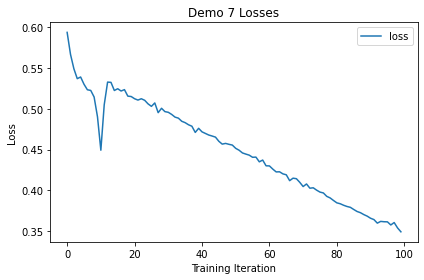

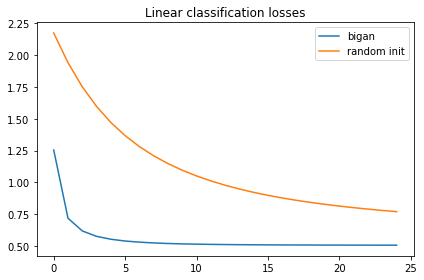

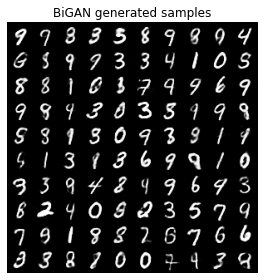

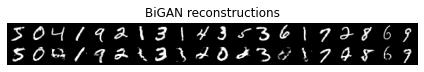

BiGAN final linear classification loss: 0.5068997717869561
Random encoder linear classification loss: 0.7704796796160212


In [0]:
ptu.set_gpu_mode(True)
demo7_save_results(demo7)

The BiGAN samples look quite good, and the trained encoder learns useful representations that the linear classifer can take advantage of for digit classification. The fact that the random encoder achieves much worse classification loss indicates that it isn't just the inductive bias of the encoder, but the actual features learned that make the difference in linear classification accuracy. 